In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from itertools import product
from sfp_nsdsyn import utils
from pysurfer.mgz_helper import get_vertices_in_labels, read_label, get_existing_labels_only

%load_ext autoreload
%autoreload 2

# Configurations

In [2]:
nsd_dir ='/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset'
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
fs_subj_dir='/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsddata/freesurfer'
overlay_dir='/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn'
fig_dir='/Volumes/server/Projects/sfp_nsd/derivatives/figures/brain_maps/nsdsyn'
sn_list = [f'subj{sn:02d}' for sn in np.arange(1,9)]

In [3]:
# Additional matplotlib preferences:
font_data = {'family':'sans-serif',
             'sans-serif':['HelveticaNeue', 'Helvetica', 'Arial'],
             'size': 10}
mpl.rc('font',**font_data)
# we want relatively high-res images, especially when saving to disk.
#mpl.rcParams['figure.dpi'] = 72*2
#mpl.rcParams['savefig.dpi'] = 72*4

# Load base frequency preference maps

In [20]:
labels = ['V1v', 'V1d', 'V2v','V2d', 'V3v','V3d', 'hV4', 'aFFA', 'pFFA', 'PPA']
sn = 'subj01'
hemi = 'lh'
label_path = [os.path.join(fs_subj_dir, sn, 'label', f'{hemi}.V1v.label')]

## load in labels for each subject

In [6]:
lh_rois = {}
rh_rois = {}

for sn in sn_list:
    label_dir = os.path.join(fs_subj_dir, sn, 'label')
    lh_labels, lh_label_paths = get_existing_labels_only(labels, label_dir, 'lh', return_paths=True)
    rh_labels, rh_label_paths = get_existing_labels_only(labels, label_dir, 'rh', return_paths=True)

    mgz_path = os.path.join(overlay_dir, f'lh.sub-{sn}_value-mode_masked.mgz')
    lh_rois[sn] = get_vertices_in_labels(mgz_path, lh_label_paths, lh_labels, load_mgz=True, load_label=True)

    mgz_path = os.path.join(overlay_dir, f'rh.sub-{sn}_value-mode_masked.mgz')
    rh_rois[sn] = get_vertices_in_labels(mgz_path, rh_label_paths, rh_labels, load_mgz=True, load_label=True)

## turn them into one dataframe

In [8]:
all_df = pd.DataFrame({})
for sn in sn_list:
    # Convert the dictionary to a DataFrame
    data_df = pd.DataFrame({key: pd.Series(value) for key, value in lh_rois[sn].items()})
    # Melt the DataFrame to have ROI values in a single column
    melted_data = data_df.melt(var_name='ROI', value_name='base frequency preference')
    melted_data['hemi'] = 'lh'

    data_df = pd.DataFrame({key: pd.Series(value) for key, value in rh_rois[sn].items()})
    # Melt the DataFrame to have ROI values in a single column
    melted_data_2 = data_df.melt(var_name='ROI', value_name='base frequency preference')
    melted_data_2['hemi'] = 'rh'

    tmp = pd.concat((melted_data, melted_data_2), axis=0)
    tmp['sn'] = sn
    all_df = pd.concat((all_df, tmp), axis=0)

In [10]:
# Define a colormap from Matplotlib
cmap = plt.cm.get_cmap('Blues_r')

# Define the number of colors based on the number of ROIs
ret_colors = [cmap(i / 10) for i in range(10)]
colors = []
colors += [ret_colors[0], ret_colors[0], ret_colors[2], ret_colors[2], ret_colors[4], ret_colors[4], ret_colors[6]]
# Define a colormap from Matplotlib
colors += ['magenta', 'magenta']
colors += ['gray']
palette = dict(zip(labels, colors))

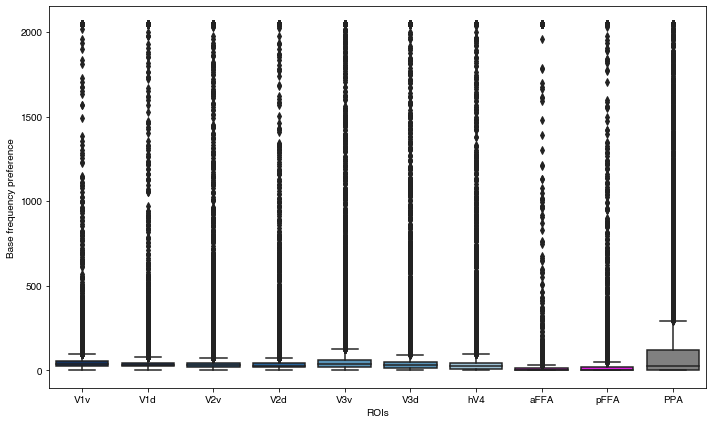

In [11]:
# Set the size of the figure
plt.figure(figsize=(10, 6))  # Adjust the size as needed
ax = sns.boxplot(x='ROI', y='base frequency preference', data=all_df, palette=palette, order=labels)
ax.set_ylabel('Base frequency preference')
#ax.set_ylim(-10, 300)
ax.set_xlabel('ROIs')
plt.tight_layout()

# goodness of fit

In [16]:
lh_rois = {}
rh_rois = {}
my_val = 'r2'
thres=0
ref_frame='absolute'
for sn in sn_list:
    label_dir = os.path.join(fs_subj_dir, sn, 'label')
    lh_labels, lh_label_paths = get_existing_labels_only(labels, label_dir, 'lh', return_paths=True)
    rh_labels, rh_label_paths = get_existing_labels_only(labels, label_dir, 'rh', return_paths=True)

    mgz_path = os.path.join(overlay_dir, f'lh.mask-precision_sub-{sn}_value-{my_val}_thres-{thres}_frame-{ref_frame}.mgz')
    lh_rois[sn] = get_vertices_in_labels(mgz_path, lh_label_paths, lh_labels, load_mgz=True, load_label=True)

    mgz_path = os.path.join(overlay_dir, f'rh.sub-{sn}_value-{my_val}.mgz')
    rh_rois[sn] = get_vertices_in_labels(mgz_path, rh_label_paths, rh_labels, load_mgz=True, load_label=True)

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn/lh.mask-precision_sub-subj01_value-r2_thres-0_frame-absolute.mgz'

In [83]:
new_df = pd.DataFrame({})
for sn, hemi, roi in product(sn_list, ['lh','rh'], labels):
    tmp = all_df.query('ROI == @roi & hemi == @hemi & sn == @sn')
    all_counts = len(tmp['base frequency preference'])
    if all_counts != 0:
        nan_counts = np.divide(sum(np.isnan(tmp['base frequency preference'])), all_counts)*100
        tmp = pd.DataFrame({'roi': [roi],
                            'sn': [sn],
                            'hemi': [hemi],
                            'nan_percent': [nan_counts]})
        new_df = pd.concat((new_df, tmp), axis=0)


In [90]:
new_df = new_df.groupby(['roi','sn']).mean().reset_index()

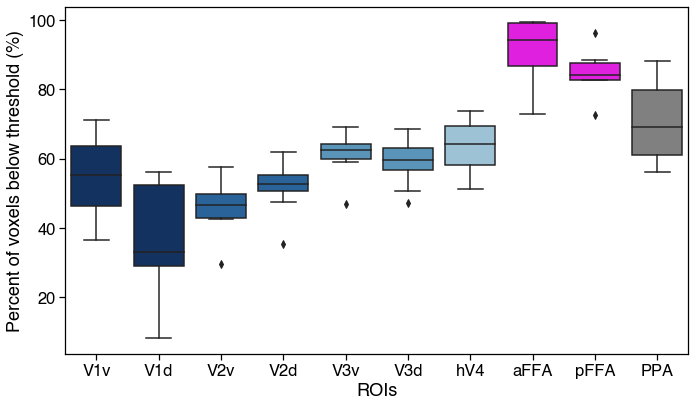

In [93]:
sns.set_context("notebook", font_scale=1.5)

# Set the size of the figure
plt.figure(figsize=(10, 6))  # Adjust the size as needed
ax = sns.boxplot(x='roi', y='nan_percent', data=new_df, palette=palette, order=labels)
ax.set_ylabel('Percent of voxels below threshold (%)')
ax.set_xlabel('ROIs')
plt.tight_layout()

In [ ]:
sns.set_context("notebook")
# Create a figure with subplots



fig, axs = plt.subplots(nrows=1, ncols=len(labels), figsize=(12, 5), sharey=True)
# Use a for loop to create violin plots for each subject
for i, ax in enumerate(axs):
    sns.boxplot(data=all_precisions[i], color=colors[i], ax=ax)
    ax.set_title('Subject {}'.format(i+1))
    ax.set_ylim(-0.05, 8)
    ax.set_xticks([])
    ax.set_xticklabels([])

# Set common ylabel
fig.text(0.08, 0.5, 'Precision values', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'Subjects', ha='center', va='center')
fig.suptitle('Distribution of Precision Values for Each Subject', y=1.02)

# Show the plot
utils.save_fig(os.path.join(fig_dir, 'quantification', 'violinplot_sub-all_value-precision.png'))
plt.show()